# 调用必备库

In [18]:
import time
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim



# 先随便搭建个简单的神经网络


尝试求解一下两端点固定的自由振动问题

$u_{tt}-a^2u_{xx}=0$

$u(0,x)=sinx$

$u_t(0,x)=cosx$

$u(t,0)=0,u(l,t)=0$




## 神经网络求解

In [19]:
class zsrDGM_net(nn.Module):
    def __init__(self,numl,numn):
        # numl是有多少层隐藏层
        # numn是每层的神经元数量
        super(zsrDGM_net, self).__init__()
        self.input_layer = nn.Linear(2, numn)#前面的数字代表几个输入
        self.hidden_layers = nn.ModuleList([nn.Linear(numn, numn) for i in range(numl)])
        self.output_layer = nn.Linear(numn, 1)
    def forward(self, x):
        o = self.act(self.input_layer(x))
        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))        
        out = self.output_layer(o)        
        return out
    def act(self, x):
        return x * torch.tanh(x)

In [20]:
class PDE():
    def __init__(self, net, a,l,t):
        self.net=net
        self.a=a
        self.l=l
        self.t=t
    def sample(self,size=2**11):        
        x = torch.cat((torch.rand([size, 1]) * self.t, torch.rand([size, 1]) * self.l), dim=1)
        x_init = torch.rand([size, 1]) * self.l
        x_initial = torch.cat((torch.zeros(size, 1), x_init), dim=1)
        x_boundary_left = torch.cat((torch.rand([size, 1])*self.t, torch.full([size, 1], 0)), dim=1)
        x_boundary_right = torch.cat((torch.rand([size, 1])*self.t, torch.full([size, 1], l)), dim=1)
        return x, x_initial, x_init, x_boundary_left, x_boundary_right
    def loss_func(self,size=2**11):
        x_train, x_initial, x_init, x_boundary_left, x_boundary_right = self.sample(size=size)
        x = Variable(x_train, requires_grad=True)
        d = torch.autograd.grad(net(x), x, grad_outputs=torch.ones_like(net(x)), create_graph=True)
        dt = d[0][:, 0].unsqueeze(-1)
        dx = d[0][:, 1].unsqueeze(-1)
        dxx = torch.autograd.grad(dx, x, grad_outputs=torch.ones_like(dx), create_graph=True)[0][:, 1].unsqueeze(-1)
        dtt = torch.autograd.grad(dt, x, grad_outputs=torch.ones_like(dt), create_graph=True)[0][:, 0].unsqueeze(-1)
        x2=Variable(x_initial, requires_grad=True)
        x3=Variable(x_boundary_right, requires_grad=True)
        d1 = torch.autograd.grad(net(x2), x2, grad_outputs=torch.ones_like(net(x2)), create_graph=True)
        d2 = torch.autograd.grad(net(x3), x3, grad_outputs=torch.ones_like(net(x3)), create_graph=True)
        dt1 = d1[0][:, 0].unsqueeze(-1)
        dx2=  d2[0][:, 1].unsqueeze(-1)
        loss_fn = nn.MSELoss(reduction='mean')
        loss1 = loss_fn(dtt, self.a**2*dxx)
        loss2 = loss_fn(net(x_initial), torch.zeros([size,1])+torch.full([size, 1], 0))
        loss3 = loss_fn(net(x_boundary_left),torch.zeros([size,1])+torch.full([size, 1], 0))
        loss4 = loss_fn(dx2, torch.zeros([size,1])+torch.full([size, 1], 0))
        loss5 = loss_fn(dt1,torch.zeros([size,1])+torch.full([size, 1], 1))
        loss = loss1 + loss2 + loss3+ loss4+  loss5
        return loss
        

In [21]:
class Train():
    def __init__(self, net, eq, BATCH_SIZE):
        self.errors = []
        self.BATCH_SIZE = BATCH_SIZE
        self.net = net
        self.model = eq
    def train(self, epoch, lr):
        optimizer = optim.Adam(self.net.parameters(), lr)
        avg_loss = 0
        for e in range(epoch):
            optimizer.zero_grad()
            loss = self.model.loss_func(self.BATCH_SIZE)
            avg_loss = avg_loss + float(loss.item())
            loss.backward()
            optimizer.step()
            if e % 50 == 49:
                loss = avg_loss/50
                print("Epoch {} - lr {} -  loss: {}".format(e, lr, loss))
                avg_loss = 0

                error = self.model.loss_func(2**11)
                self.errors.append(error.detach())
    def get_errors(self):
        return self.errors

In [22]:
net = zsrDGM_net(numl=6, numn=250)
a=1
l=1
t=1
equation = PDE(net, a, l,t)
train = Train(net, equation, BATCH_SIZE=2**11)
train.train(epoch=2000, lr=0.001)
torch.save(net, 'test.pkl')
errors = train.get_errors()

Epoch 49 - lr 0.001 -  loss: 0.8389416944980621
Epoch 99 - lr 0.001 -  loss: 0.14445764239877462
Epoch 149 - lr 0.001 -  loss: 0.01242664210498333
Epoch 199 - lr 0.001 -  loss: 0.00564631930552423
Epoch 249 - lr 0.001 -  loss: 0.00557897450402379
Epoch 299 - lr 0.001 -  loss: 0.0049186527729034426
Epoch 349 - lr 0.001 -  loss: 0.003905675425194204
Epoch 399 - lr 0.001 -  loss: 0.003935082126408815
Epoch 449 - lr 0.001 -  loss: 0.0037376348907127975
Epoch 499 - lr 0.001 -  loss: 0.0033540036994963883
Epoch 549 - lr 0.001 -  loss: 0.003301810291595757
Epoch 599 - lr 0.001 -  loss: 0.002661938851233572
Epoch 649 - lr 0.001 -  loss: 0.002457278638612479
Epoch 699 - lr 0.001 -  loss: 0.0036616180185228588
Epoch 749 - lr 0.001 -  loss: 0.0015363467019051313
Epoch 799 - lr 0.001 -  loss: 0.0029854813241399825
Epoch 849 - lr 0.001 -  loss: 0.0014706133888103068
Epoch 899 - lr 0.001 -  loss: 0.0019788104319013655
Epoch 949 - lr 0.001 -  loss: 0.002107994417892769
Epoch 999 - lr 0.001 -  loss: 0

In [23]:
fig = plt.figure()
plt.plot(np.log(errors), '-b', label='Errors')
plt.title('Training Loss', fontsize=10)
plt.savefig('error.jpg')
plt.close(fig)

In [24]:
x = [[i/100] for i in range(0,100)]
t = torch.tensor([[i/100] for i in range(0,100)])
Z=[]
for i in x:
    u = torch.cat((torch.full([100, 1],i[0]),t), dim=1)
    net=torch.load('test.pkl')
    usolve=net(u)
    usolve=usolve.detach().numpy()
    Z.append(usolve)

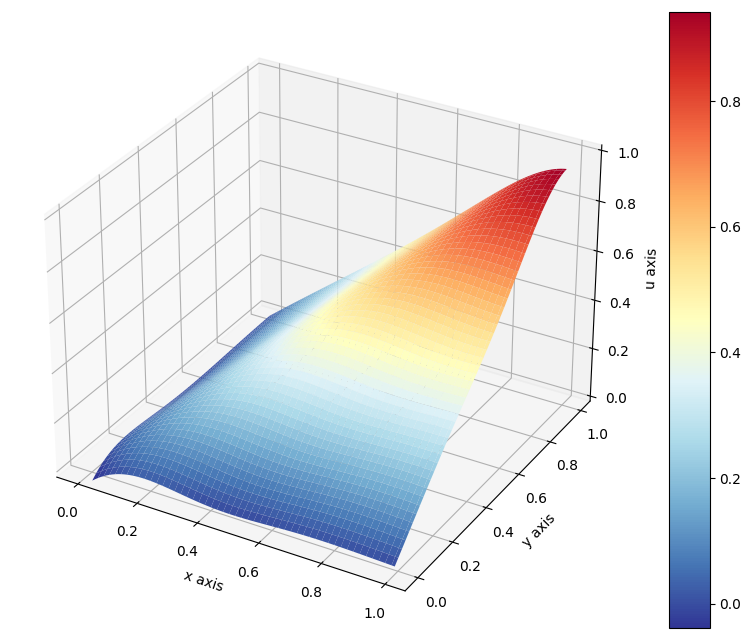

In [25]:
xd=np.array([[i/100] for i in range(0,100)])
yd=np.array([[i/100] for i in range(0,100)])
_X, _Y = np.meshgrid(xd, yd, indexing='ij')
True_Z_surface1 = np.reshape(Z, (xd.shape[0], yd.shape[0]))
fig = plt.figure(figsize=(10, 10), facecolor='white') #创建图片
sub = fig.add_subplot(111, projection='3d')# 添加子图，
sub.set_zlim([0, 1])
#ax = fig.gca(projection='3d')
surf=sub.plot_surface(_X, _Y, True_Z_surface1, cmap=plt.cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
cb = fig.colorbar(surf, shrink=0.8, aspect=15) #设置颜色棒
sub.set_xlabel(r"x axis")
sub.set_ylabel(r"y axis")
sub.set_zlabel(r"u axis")
plt.show()

误差 

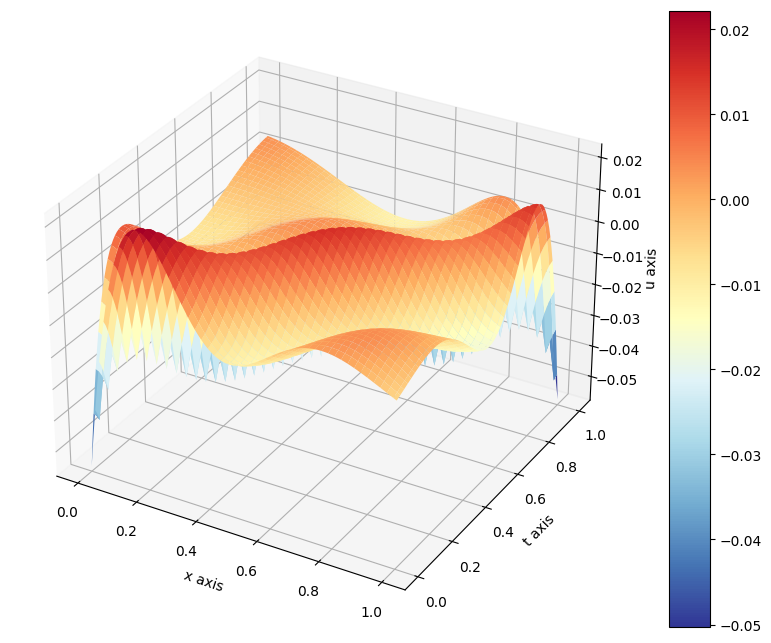

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from mpl_toolkits.mplot3d import Axes3D # 用于绘制3D图案
t= np.linspace(0,1,100)
x= np.linspace(0,1,100)
x_,t_ = np.meshgrid(x,t,indexing='ij') 
f=0
for n in range(0,1000):
    g=1/(2*n+1)**2*np.sin((2*n+1)*pi*t_/2)
    v=np.sin((2*n+1)*pi*x_/2)
    f=f+g*v
u=8/pi**2*f
fig = plt.figure(figsize=(10, 10), facecolor='white') #创建图片
sub = fig.add_subplot(111, projection='3d')# 添加子图，
surf = sub.plot_surface(x_, t_, True_Z_surface1-u, cmap=plt.cm.RdYlBu_r) #绘制曲面,cmap=plt.cm.brg并设置颜色cmap
cb = fig.colorbar(surf, shrink=0.8, aspect=15) #设置颜色棒
 
sub.set_xlabel(r"x axis")
sub.set_ylabel(r"t axis")
sub.set_zlabel(r"u axis")
plt.show()
